## Trying to quantify the power of the LLR for RX

A real dummy example which attempts to show what is gained by using a LLR for an alternate hypothesis as opposed to a simple chi2 test on the null hypothesis only.

Here we assume 4 bins which varying sensitivty which approximately replicate the RX measurement.

The null hypothesis is straightforward (RX=1 for all bins).

In the case where we want to test an alternate hypothesis I make one up which expected 0.85 in each bin apart from the low q2 RKstar bin which expects 0 (this is not disimilar to the EFT best fit).

To try and summarise in words why the LLR is more powerful than the chi2:
 - the chi2 test sums the pulls (squared) from obs to null in each bin but has 4 bins (so 4 degrees of freedom)

- the LLR test sums the pulls (squared) from obs to null and then obs to alternate in each bin and then computes the difference. This will be smaller than above but now there is only one degree of freedom. In this example it really is only one degree of freedom (beacuse there is one signal strength parameter varied in the likelihood). 

Test      Statistic    ndof       p-val    significance
------  -----------  ------  ----------  --------------
chisq       11.9922       4  0.0174096          2.37794
LLR         10.7254       1  0.00105674         3.27497


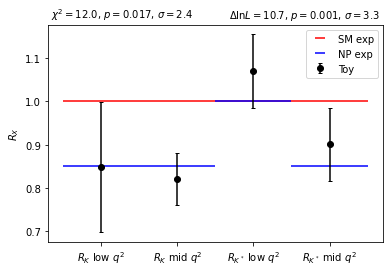

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# set reproducible seed
np.random.seed(210186)
from scipy.stats import chi2 as chi2dist
from scipy.stats import norm
from tabulate import tabulate
from iminuit import Minuit
import pandas as pd

# set expectations
bins = ['RK_low','RK_mid','RKst_low','RKst_mid']
labels = ['$R_K$ low $q^2$','$R_K$ mid $q^2$','$R_{K^*}$ low $q^2$','$R_{K^*}$ mid $q^2$']
SM = np.array([1,1,1,1])
NP = np.array([0.85,0.85,1,0.85])
RX_errs = np.array([0.15,0.06,0.085,0.085])

global toy

# can scale up the errors by a factor here
scale = 1
RX_errs /= scale**0.5

### some useful functions ###
### JUST SKIP THIS WHOLE BOX IF YOU JUST WANT TO SEE THE RESULTS ###
def plot(ax=None, toy=None, stats=None):
    ax = ax or plt.gca()
    ax.errorbar( np.arange(4), SM, xerr=0.5, fmt='ro', ms=0, capsize=0, label='SM exp' )
    ax.errorbar( np.arange(4), NP, xerr=0.5, fmt='bo', ms=0, capsize=0, label='NP exp' )
    if toy is not None:
        ax.errorbar( np.arange(4), toy, yerr=RX_errs, fmt='ko', capsize=2, label='Toy')
    ax.set_xticks( np.arange(4) )
    ax.set_xticklabels( labels )
    ax.set_ylabel('$R_X$')
    if stats is not None:
        ax.text(0.01,1.03, '$\chi^2 = {:4.1f}$, $p = {:5.3f}$, $\sigma = {:3.1f}$'.format(*stats[0]), transform=ax.transAxes, ha='left')
        ax.text(0.99,1.03, '$\Delta\ln L = {:4.1f}$, $p = {:5.3f}$, $\sigma = {:3.1f}$'.format(*stats[1]), transform=ax.transAxes, ha='right')
    ax.legend()


def gen_toy(new=True):
    central = NP if new else SM
    return np.array([ np.random.normal(val, err) for val, err in zip(NP,RX_errs)])

def chi2(toy, new=False, rem=None):
    obs = toy
    exp = NP if new else SM
    err = RX_errs
    nam = bins
    if rem is not None:
        obs = np.delete(obs,rem)
        exp = np.delete(exp,rem)
        err = np.delete(err,rem)
        nam = np.delete(bins,rem)
        
    # computes chi2s
    chisqs = [ (ex-ob)**2 / er**2 for ex,ob,er in zip(exp,obs,err) ]
    
    return np.sum(chisqs)

def pdf(mu):
    exp = SM - (SM-NP)*mu
    return exp

def nll_min(mu):
    global toy
    return np.sum((toy-pdf(mu))**2/RX_errs**2)

def toy_comp(ax=None,quiet=True):
    global toy
    toy = gen_toy()

    pr_rows = []
    
    ## do the chisq test to background ##
    chisq = chi2(toy, new=False)
    chisq_pval = 1 - chi2dist.cdf(chisq,len(toy))
    chisq_signif = chi2dist.ppf(1-chisq_pval,1)**0.5
    #print(chisq,chisq_pval,chisq_signif)
    pr_rows.append( ['chisq', chisq, len(toy), chisq_pval, chisq_signif])
    
    ## do the LLR test to alternate ##
    
    # fit for the signal strength first
    m = Minuit(nll_min, mu=1)
    m.errordef = 1
    m.limits['mu'] = (-5,5)
    m.migrad()
    m.hesse()
    #print(m)
    #print( m.fval, nll_min(1), nll_min(0) )
    dll = (nll_min(0) - m.fval )
    sig = dll**0.5
    pval = 1-chi2dist.cdf(dll,1)
    pr_rows.append( ['LLR', dll, 1, pval, sig])
    #print(dll,pval,sig)
    
    if not quiet:
        print(tabulate(pr_rows,headers=['Test','Statistic','ndof','p-val','significance']))
    
    if ax is not None:
        plot(ax,toy)
    
    return ( toy, (chisq, chisq_pval, chisq_signif), (dll,pval,sig) )

# generate a test toy and plot it
fig, ax = plt.subplots()
toy, chisq, dnll = toy_comp(quiet=False)
plot(ax,toy,stats=(chisq,dnll))

## Now you can see what we are dealing with


In [2]:
## Now run many toys and save the results in a dataframe

tvals = []
chisqs = []
nlls = []

ntoys = 20000
for i in range(ntoys):
    toy, chisq, nll = toy_comp()
    if np.isfinite( chisq[2] ):
        chisqs.append(np.array(chisq))
        nlls.append(np.array(nll))
        tvals.append(np.array(toy))

tvals = np.array(tvals)
chisqs = np.array(chisqs)
nlls = np.array(nlls)

df = pd.DataFrame( tvals, columns = bins )
df['chi2'] = chisqs[:,0]
df['chi2_pval'] = chisqs[:,1] 
df['chi2_sig'] = chisqs[:,2]
df['dnll'] = nlls[:,0]
df['dnll_pval'] = nlls[:,1]
df['dnll_sig'] = nlls[:,2]
#print(df)


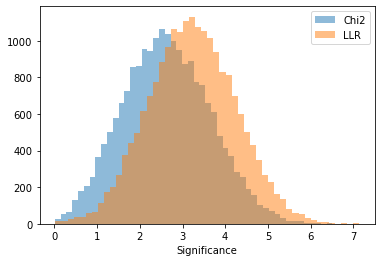

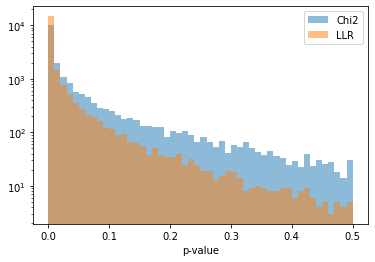

In [3]:
## plot comparison of chi2 and LLR p-values and significances
fig, ax = plt.subplots()
ax.hist( df['chi2_sig'], alpha=0.5, bins=50, label='Chi2')
ax.hist( df['dnll_sig'], alpha=0.5, bins=50, label='LLR')
ax.set_xlabel('Significance')
ax.legend()

fig, ax = plt.subplots()
ax.hist( df['chi2_pval'], alpha=0.5, bins=50, range=(0,0.5), label='Chi2')
ax.hist( df['dnll_pval'], alpha=0.5, bins=50, range=(0,0.5), label='LLR')
ax.set_xlabel('p-value')
ax.legend()
ax.set_yscale('log')




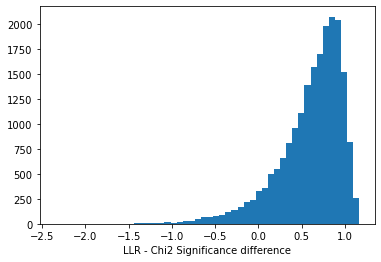

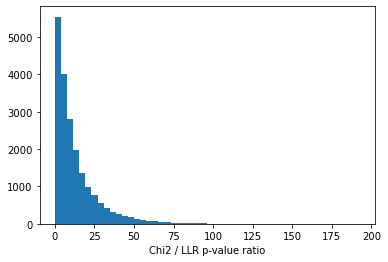

In [4]:
# plot difference of sigma and ratio of pvals

fig, ax = plt.subplots()
_ = ax.hist( df['dnll_sig']-df['chi2_sig'], bins=50)
_ = ax.set_xlabel('LLR - Chi2 Significance difference')

fig, ax = plt.subplots()
_ = ax.hist( df['chi2_pval'] / df['dnll_pval'] ,  bins=50)
_ = ax.set_xlabel('Chi2 / LLR p-value ratio')

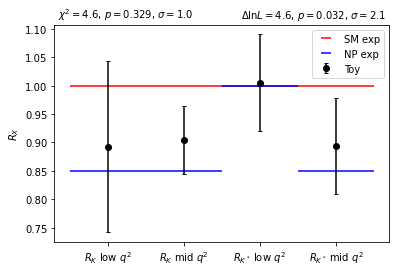

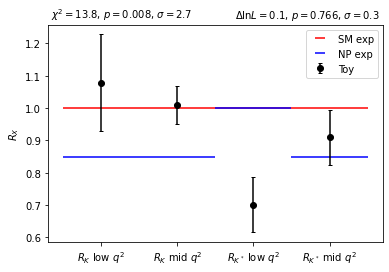

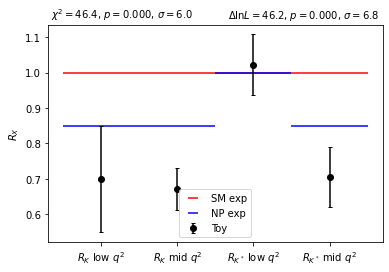

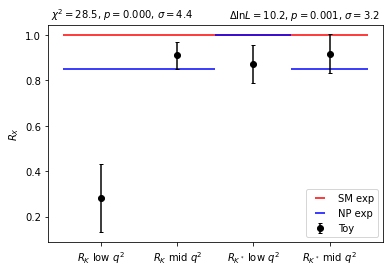

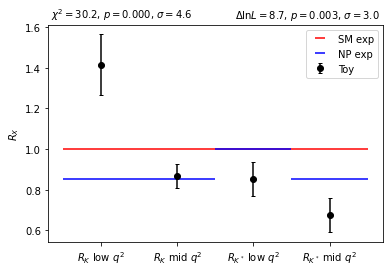

In [6]:
# plot some specific corner case toys
interesting_toys = []

# toy with smallest RK low q2 value
interesting_toys.append( df['RK_low'].to_numpy().argmin() )

# toy with biggest p-value ratio
interesting_toys.append( (df['chi2_pval'] / df['dnll_pval']).to_numpy().argmax() )

# toy with smallest p-value ratio
interesting_toys.append( (df['chi2_pval'] / df['dnll_pval']).to_numpy().argmin() )

# toy with biggest sigma difference
interesting_toys.append( (df['chi2_sig'] - df['dnll_sig']).to_numpy().argmax() )

# toy with smallest sigma difference
interesting_toys.append( (df['chi2_sig'] - df['dnll_sig']).to_numpy().argmin() )

interesting_toys = set(interesting_toys)

for itoy in interesting_toys:
    fig, ax = plt.subplots()
    plot(ax, df.iloc[itoy].to_numpy()[:4], stats=(df[['chi2','chi2_pval','chi2_sig']].iloc[itoy].to_numpy(),df[['dnll','dnll_pval','dnll_sig']].iloc[itoy].to_numpy()))
